## Imports/Setup

In [13]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Mixed Layer Depth (MLD)

#### deBoyer

In [2]:
#MLD data is just one year of data that was processed by the author using several years of temperature profiles (data from 1941-2008, partially missing)
#More info found on https://cerweb.ifremer.fr/deboyer/mld/Surface_Mixed_Layer_Depth.php

mld_direct_url = 'https://cerweb.ifremer.fr/deboyer/data/mld_DT02_c1m_reg2.0.nc'
mld_destination_folder = global_vars['download_folder']+r'MLD/originals/'
mld_destination_filename = 'MLD_IFREMER-deBoyer_DT02-c1m_2008.nc'   #2008 though data is blended across years 
download(mld_direct_url, mld_destination_folder, mld_destination_filename)

File MLD_IFREMER-deBoyer_DT02-c1m_2008.nc already exists at /data/artemis/workspace/ds4114/online_data/MLD/originals/ - (skipping download from https://cerweb.ifremer.fr/deboyer/data/mld_DT02_c1m_reg2.0.nc )


#### Argo

In [14]:
# This MLD source is from UC San Diego who used Argo data to create the climatology
# More info can be found on http://mixedlayer.ucsd.edu/ and https://www.seanoe.org/data/00311/42182/#56126
mld_direct_url = 'http://mixedlayer.ucsd.edu/data/Argo_mixedlayers_monthlyclim_04142022.nc'
mld_destination_folder = global_vars['download_folder']+r'MLD/originals/'
mld_destination_filename = 'MLD_UCSD-Argo_mixedlayers-monthlyclim_2022.nc'   #2022 though data is blended across years 
download(mld_direct_url, mld_destination_folder, mld_destination_filename)

File MLD_UCSD-Argo_mixedlayers-monthlyclim_2022.zarr already exists at gs://leap-persistent/ds4114/online_data/MLD/originals/ - (skipping download from http://mixedlayer.ucsd.edu/data/Argo_mixedlayers_monthlyclim_04142022.nc )


## Processing:  Mixed Layer Depth (MLD)

#### deBoyer

In [3]:
mld_ds = xr_open_dataset_custom(global_vars['download_folder']+r'MLD/originals/MLD_IFREMER-deBoyer_DT02-c1m_2008.nc', decode_times=False)
mld = mld_ds.mld  #just need the mld variable. Data is 2x2 resolution

In [6]:
#there are strange anomalies in the raw data which we are going to filter out
mld_filtered = mld.where(((mld>0)&(mld<5000))) 

#TODO - Document these next commands
mld_filtered2 = np.where(np.isnan(mld_filtered), ma.array(mld_filtered, mask=np.isnan(mld_filtered)).mean(axis=2)[:,:,np.newaxis], mld_filtered)
mld_filtered2 = np.where(mld_filtered2==0,np.nan,mld_filtered2)

In [8]:
mld_in = xr.Dataset({'mld':(['time','lat','lon'],mld_filtered2),'time':(['time'],range(0,12)),'lat':(['lat'],mld_filtered.lat.values),'lon':(['lon'],mld_filtered.lon.values)})

mld_regridder = xesmf.Regridder(mld_in, ideal_grid, 'bilinear', periodic=True) 
mld_out = mld_regridder(mld_filtered2, keep_attrs=True) #may need to fix for cloud storage with: mld_regridder(mld_filtered2.chunk(-1), keep_attrs=True)
mld_out = np.where(np.isnan(mld_out),0,mld_out)
#mld_out

In [9]:
#we now have 12 months of MLD data, let's replicate for the desired time frame so merging is easier later
mld_out_full = np.empty(shape=(len(ttime),180,360)) 
#now fill array with averaged year
for i, m in enumerate(ttime): 
    mld_out_full[i,:,:] = mld_out[m.month-1,:,:]
#mld_out_full

In [10]:
mld_out_full_xr = xr.Dataset({'mld':(["time","ylat","xlon"],mld_out_full.data)},
                        coords={'time': (['time'],ttime.values),'ylat':(['ylat'],ideal_grid.latitude.data),'xlon':(['xlon'],ideal_grid.longitude.data)})

In [11]:
output_xarray_with_date(mld_out_full_xr, global_vars['download_folder']+'MLD/processed/', 'MLD_IFREMER-deBoyer_DT02-c1m-1x1', output_file_type)

Saved MLD_IFREMER-deBoyer_DT02-c1m-1x1_198201-202212.nc to /data/artemis/workspace/ds4114/online_data/MLD/processed/


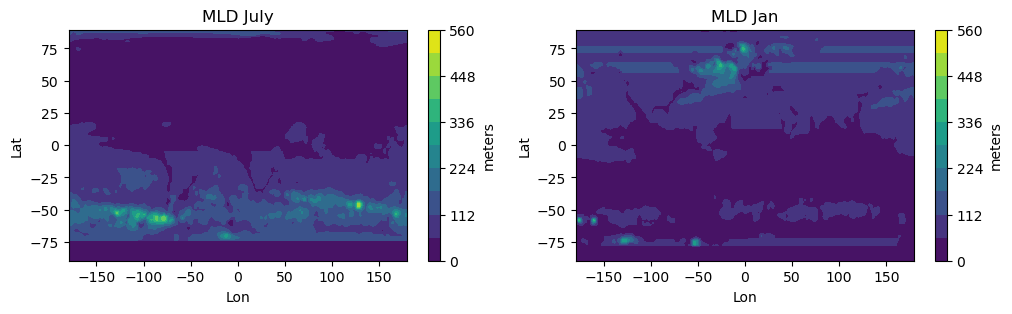

In [14]:
levelspace = np.linspace(0,560,11)
fig,ax = plt.subplots(1,2,figsize=(figsizew*2, figsizeh))
x0=ax[0].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_out_full_xr.mld[6,:,:], levels=levelspace) #just choosing a summer month (July)
x1=ax[1].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_out_full_xr.mld[0,:,:], levels=levelspace) #just choosing a winter month (Jan)
ax[0].set_title("MLD July"); ax[1].set_title("MLD Jan");
ax[0].set_xlabel('Lon'); ax[0].set_ylabel('Lat');
ax[1].set_xlabel('Lon'); ax[1].set_ylabel('Lat');
plt.colorbar(x0, ax=ax[0]).set_label('meters');
plt.colorbar(x1, ax=ax[1]).set_label('meters');

#### UCSD / Argo

In [17]:
mld_argo = xr_open_dataset_custom(global_vars['download_folder'] + r'MLD/originals/MLD_UCSD-Argo_mixedlayers-monthlyclim_2022.nc')
mld_argo = mld_argo.transpose('iMONTH','iLAT','iLON')

In [18]:
mld_argo_filled = mld_argo.mld_dt_mean.fillna(0)  #replace nan with 0 to be consistent with prior work

#Note: The coordinates for this source netCDF are assumed aligned to the same 1x1 grid
    #So regridding not required 
    #we have 12 months of MLD data, let's replicate for the desired time frame so merging is easier later
mld_argo_out_full = np.empty(shape=(len(ttime),180,360)) 
for i, m in enumerate(ttime): 
    mld_argo_out_full[i,:,:] = mld_argo_filled[m.month-1,:,:]
mld_argo_out_full_xr = xr.Dataset({'mld_argo':(["time","ylat","xlon"],mld_argo_out_full.data)},
                        coords={'time': (['time'],ttime.values),'ylat':(['ylat'],ideal_grid.latitude.data),'xlon':(['xlon'],ideal_grid.longitude.data)})
#mld_out_full_xr

In [40]:
output_xarray_with_date(mld_argo_out_full_xr, global_vars['download_folder']+'MLD/processed/', 'MLD_UCSD-Argo_MLD-dt-mean-1x1', output_file_type)

Cancelling output - MLD_UCSD-Argo_MLD-dt-mean-1x1_198201-202304.nc already exists in /data/artemis/workspace/ds4114/online_data/MLD/processed/


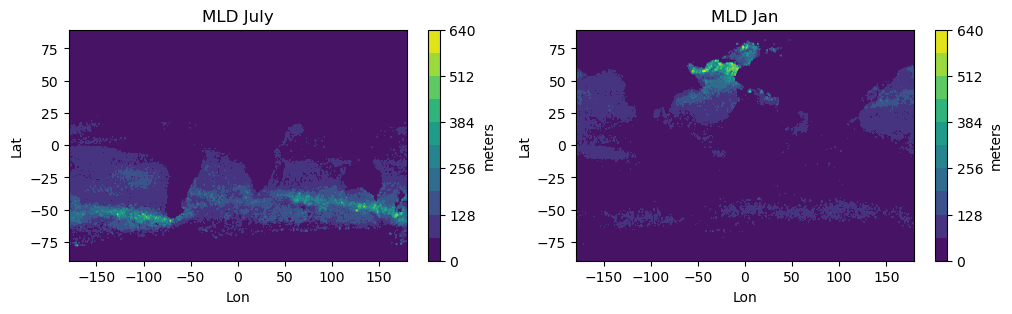

In [19]:
levelspace = np.linspace(0,640,11)
fig,ax = plt.subplots(1,2,figsize=(figsizew*2, figsizeh))
x0=ax[0].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_argo_out_full_xr.mld_argo[6,:,:], levels=levelspace) #just choosing a summer month (July)
x1=ax[1].contourf(ideal_grid.longitude,ideal_grid.latitude,mld_argo_out_full_xr.mld_argo[0,:,:], levels=levelspace) #just choosing a winter month (Jan)
ax[0].set_title("MLD July"); ax[1].set_title("MLD Jan");
ax[0].set_xlabel('Lon'); ax[0].set_ylabel('Lat');
ax[1].set_xlabel('Lon'); ax[1].set_ylabel('Lat');
plt.colorbar(x0, ax=ax[0]).set_label('meters');
plt.colorbar(x1, ax=ax[1]).set_label('meters');